In [1]:
import pandas as pd
import sys
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt

# Precinct Shapefile

## VEST's Documentation File

Election results from New Hampshire Secretary of State (https://sos.nh.gov/elections/elections/election-results/2020/general-election/). Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program final release.

The Census VTD shapefile includes wards for the Town of Berlin and the Town of Derry that are only used for municipal elections. These were merged to match the statewide election returns. 

- G20PREDBID - Joseph R. Biden (Democratic Party)
- G20PRERTRU - Donald J. Trump (Republican Party)
- G20PRELJOR - Jo Jorgensen (Libertarian Party)


- G20USSDSHA - Jeanne Shaheen (Democratic Party)
- G20USSRMES - Corky Messner (Republican Party)
- G20USSLODO - Justin O'Donnell (Libertarian Party)
- G20USSOWRI - Write-in Votes


- G20GOVDFEL - Dan Feltes (Democratic Party)
- G20GOVRSUN - Chris Sununu (Republican Party)
- G20GOVLPER - Darryl W. Perry (Libertarian Party)
- G20GOVOWRI - Write-in Votes


## Load VEST's Final File

In [97]:
vest_shp = gp.read_file("./raw-from-source/VEST/nh_2020/nh_2020.shp")

In [3]:
vest_shp.shape

(321, 18)

In [4]:
vest_shp.head(1)

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,NAMELSAD20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDSHA,G20USSRMES,G20USSLODO,G20USSOWRI,G20GOVDFEL,G20GOVRSUN,G20GOVLPER,G20GOVOWRI,geometry
0,33,019,ACWO01,33019ACWO01,TOWN OF ACWORTH,TOWN OF ACWORTH Voting District,293,269,7,311,227,11,0,229,325,8,0,"POLYGON ((-72.35628 43.25784, -72.35513 43.257..."


<AxesSubplot:>

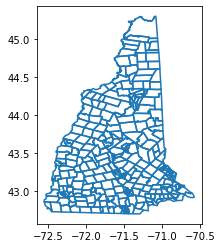

In [5]:
vest_shp.boundary.plot()

# Loading, Combining Election Results

## Load County Fips File

In [6]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="New Hampshire"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Presidential Results

In [41]:
pres_results = pd.ExcelFile('./raw-from-source/SOS/president-2020_edited.xls')

excel_tabs = {'belkpres':'Belknap','carrpres':'Carroll','chespres':'Cheshire',
              'coospres':'Coos','grafpres':'Grafton','hillspres':'Hillsborough',
              'merrpres':'Merrimack','rockpres':'Rockingham','strapres':'Strafford','sullpres':'Sullivan'}
df_list = []
for tab in excel_tabs: 
    df = pd.read_excel(pres_results, tab)
    df['County'] = excel_tabs[tab]
    df.columns = [x for x in range(len(df.columns))]
    df_list.append(df)
pres_results = pd.concat(df_list, axis = 0, ignore_index = True)
pres_results.columns = ['Precinct','G20PRERTRU','G20PREDBID','G20PRELJOR','d1','d2','County']
pres_results.drop(columns = ['d1','d2'], inplace = True)
pres_results = pres_results[(pres_results['Precinct'] != '') & (pres_results['Precinct'] != 'TOTALS') & 
                            (pres_results['G20PREDBID'].notnull()) & (pres_results['G20PRERTRU'] != 'Trump and Pence, r')]
pres_results.replace('-', np.nan, inplace = True)
pres_results['Precinct'] = pres_results['Precinct'].str.replace('*','')

<ipython-input-41-ca147f46fd9f>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  pres_results['Precinct'] = pres_results['Precinct'].str.replace('*','')


In [42]:
pres_results.sample(10)

,Precinct,G20PRERTRU,G20PREDBID,G20PRELJOR,County
82,Cambridge,4,3,0,Coos
332,Rochester Ward 3,1549,1420,68,Strafford
262,Warner,844,1050,34,Merrimack
79,Bean's Grant,0,0,0,Coos
340,Somersworth Ward 4,488,787,22,Strafford
139,Grafton,423,345,16,Grafton
354,Langdon,199,206,7,Sullivan
189,Manchester Ward 3,1174,2228,74,Hillsborough
191,Manchester Ward 5,1121,1670,74,Hillsborough
234,Concord Ward 1,979,1545,52,Merrimack


## U.S. Senate Results

In [9]:
uss_results = pd.ExcelFile('./raw-from-source/SOS/us-senator-2020_edited.xls')

excel_tabs = {'belknap gov':'Belknap','carroll gov':'Carroll','cheshire gov':'Cheshire',
              'coos gov':'Coos','grafton gov':'Grafton','hillsborough gov':'Hillsborough',
              'merrimack gov':'Merrimack','rockingham gov':'Rockingham','strafford gov':'Strafford','sullivan gov':'Sullivan'}
df_list = []
for tab in excel_tabs: 
    df = pd.read_excel(uss_results, tab)
    df['County'] = excel_tabs[tab]
    df.columns = [x for x in range(len(df.columns))]
    df_list.append(df)
uss_results = pd.concat(df_list, axis = 0, ignore_index = True)
uss_results.columns = ['Precinct','G20USSRMES','G20USSDSHA','G20USSLODO','G20USSOWRI','d1','d2']
uss_results.replace(' ', np.nan, inplace = True)
uss_results['County'] = uss_results.d1.combine_first(uss_results.d2)
uss_results.drop(columns = ['d1','d2'], inplace = True)
uss_results = uss_results[(uss_results['Precinct'] != '') & (uss_results['Precinct'] != 'TOTALS') & 
                            (uss_results['G20USSRMES'] != 'United States Senator') & (uss_results['G20USSRMES'] != 'Messner, r')]
uss_results.replace('-', np.nan, inplace = True)
uss_results = uss_results[(uss_results['Precinct'] != '*corrections received') & \
                          (uss_results['Precinct'] != '*correction received') & (uss_results['Precinct'] != ' ')]
uss_results['Precinct'] = uss_results['Precinct'].str.replace('*','')

<ipython-input-9-78aabe00062c>:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  uss_results['Precinct'] = uss_results['Precinct'].str.replace('*','')


In [10]:
uss_results.sample(10)

,Precinct,G20USSRMES,G20USSDSHA,G20USSLODO,G20USSOWRI,County
301,Portsmouth Ward 1,773.0,2108.0,83.0,0.0,Rockingham
297,North Hampton,1316.0,2082.0,49.0,3.0,Rockingham
259,New London,1039.0,2067.0,39.0,1.0,Merrimack
99,Green's Grant,0.0,1.0,0.0,0.0,Coos
118,Stratford,120.0,172.0,7.0,0.0,Coos
271,NaN,NaN,NaN,NaN,NaN,Rockingham
29,Freedom,475.0,583.0,21.0,0.0,Carroll
73,Winchester,815.0,1089.0,68.0,0.0,Cheshire
250,Epsom,1477.0,1342.0,69.0,2.0,Merrimack
18,NaN,NaN,NaN,NaN,NaN,Belknap


In [11]:
uss_results.groupby('County').count()

,Precinct,G20USSRMES,G20USSDSHA,G20USSLODO,G20USSOWRI
County,,,,,
Belknap,16,16,16,16,16
Carroll,19,19,19,19,19
Cheshire,27,27,27,27,27
Coos,43,27,27,27,27
Grafton,42,42,42,42,42
Hillsborough,50,50,50,50,50
Merrimack,38,38,38,38,38
Rockingham,41,41,41,41,41
Strafford,27,27,27,27,27


## Governor Results

In [19]:
gov_results = pd.ExcelFile('./raw-from-source/SOS/governor-2020_edited.xls')

excel_tabs = {'belknap gov':'Belknap','carroll gov':'Carroll','cheshire gov':'Cheshire',
              'coos gov':'Coos','grafton gov':'Grafton','hillsborough gov':'Hillsborough',
              'merrimack gov':'Merrimack','rockingham gov':'Rockingham','strafford gov':'Strafford','sullivan gov':'Sullivan'}
df_list = []
for tab in excel_tabs: 
    df = pd.read_excel(gov_results, tab)
    df['County'] = excel_tabs[tab]
    df.columns = [x for x in range(len(df.columns))]
    df_list.append(df)
gov_results = pd.concat(df_list, axis = 0, ignore_index = True)
gov_results.columns = ['Precinct','G20GOVRSUN','G20GOVDFEL','G20GOVLPER','G20GOVOWRI','County']
gov_results = gov_results[(gov_results['Precinct'] != '') & (gov_results['Precinct'] != 'TOTALS') & 
                            (gov_results['G20GOVRSUN'] != 'Governor ') & (gov_results['G20GOVRSUN'] != 'Sununu, r') & 
                            (gov_results['G20GOVRSUN'] != 'Governor') & (gov_results['G20GOVRSUN'] != 'Governor  ') &
                            (gov_results['Precinct'] != 'November 3,2020') & 
                            (gov_results['Precinct'] != ' ')]
gov_results.replace('-', np.nan, inplace = True)
gov_results['Precinct'] = gov_results['Precinct'].str.replace('*','')

<ipython-input-19-be2b630a02f0>:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  gov_results['Precinct'] = gov_results['Precinct'].str.replace('*','')


In [20]:
gov_results.sample(10)

,Precinct,G20GOVRSUN,G20GOVDFEL,G20GOVLPER,G20GOVOWRI,County
111,Sargent's Purchase,NaN,NaN,NaN,NaN,Coos
143,Hanover,1742.0,5020.0,76.0,2.0,Grafton
190,Manchester Ward 2,3062.0,1908.0,84.0,6.0,Hillsborough
6,Laconia Ward 1,1317.0,421.0,15.0,1.0,Belknap
82,Cambridge,7.0,0.0,0.0,0.0,Coos
71,Walpole,1282.0,998.0,42.0,3.0,Cheshire
122,NaN,NaN,NaN,NaN,NaN,Coos
339,Somersworth Ward 1,881.0,565.0,20.0,2.0,Strafford
282,Fremont,2154.0,635.0,37.0,1.0,Rockingham
154,Livermore,0.0,0.0,0.0,0.0,Grafton


## Combine Results

In [44]:
print(pres_results.shape, uss_results.shape, gov_results.shape)

(320, 5) (338, 6) (333, 6)


In [58]:
election_results = uss_results.merge(gov_results, how = 'outer', on = ['County','Precinct'], indicator = True)
display(election_results.shape)
display(election_results[election_results['_merge'] != 'both'].sort_values(['County','Precinct']))

(349, 11)

,Precinct,G20USSRMES,G20USSDSHA,G20USSLODO,G20USSOWRI,County,G20GOVRSUN,G20GOVDFEL,G20GOVLPER,G20GOVOWRI,_merge


In [59]:
election_results.drop(columns = ['_merge'], inplace = True)
election_results['Precinct'] = election_results['Precinct'].astype(str).apply(lambda x: x.strip())
pres_results['Precinct'] = pres_results['Precinct'].apply(lambda x: x.strip())
pres_results.loc[pres_results['Precinct'] == "Wentworth's Loc.", 'Precinct'] = "Wentworth's Location"

In [60]:
election_results = election_results.merge(pres_results, how = 'outer', on = ['County','Precinct'], indicator = True)
election_results = election_results.dropna(subset=['G20USSRMES', 'G20USSDSHA', 'G20USSLODO', 'G20USSOWRI',
       'G20GOVRSUN', 'G20GOVDFEL', 'G20GOVLPER', 'G20GOVOWRI',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR'], how='all')
display(election_results.shape)
display(election_results[election_results['_merge'] != 'both'].sort_values(['County','Precinct']))

(320, 14)

,Precinct,G20USSRMES,G20USSDSHA,G20USSLODO,G20USSOWRI,County,G20GOVRSUN,G20GOVDFEL,G20GOVLPER,G20GOVOWRI,G20PRERTRU,G20PREDBID,G20PRELJOR,_merge
349,Atk. & Gilm. Ac. Gt.,NaN,NaN,NaN,NaN,Coos,NaN,NaN,NaN,NaN,0,0,0,right_only
350,Low & Burbank's Gt.,NaN,NaN,NaN,NaN,Coos,NaN,NaN,NaN,NaN,0,0,0,right_only
351,Second College Gt.,NaN,NaN,NaN,NaN,Coos,NaN,NaN,NaN,NaN,0,0,0,right_only
352,Thompson & Mes's Pur.,NaN,NaN,NaN,NaN,Coos,NaN,NaN,NaN,NaN,0,0,0,right_only


In [61]:
vest_shp.shape

(321, 18)

# Validating Election Results

## Race Totals

In [62]:
election_results.columns

Index(['Precinct', 'G20USSRMES', 'G20USSDSHA', 'G20USSLODO', 'G20USSOWRI',
       'County', 'G20GOVRSUN', 'G20GOVDFEL', 'G20GOVLPER', 'G20GOVOWRI',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', '_merge'],
      dtype='object')

In [64]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))


data_columns = ['G20USSRMES', 'G20USSDSHA', 'G20USSLODO', 'G20USSOWRI',
       'G20GOVRSUN', 'G20GOVDFEL', 'G20GOVLPER', 'G20GOVOWRI',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR']

statewide_totals_check(vest_shp, election_results, data_columns)

***Statewide Totals Check***
G20USSRMES is equal 	VEST / RDH: 326229
G20USSDSHA is equal 	VEST / RDH: 450778
G20USSLODO is equal 	VEST / RDH: 18421
G20USSOWRI is equal 	VEST / RDH: 486
G20GOVRSUN is equal 	VEST / RDH: 516609
G20GOVDFEL is equal 	VEST / RDH: 264639
G20GOVLPER is equal 	VEST / RDH: 11329
G20GOVOWRI is equal 	VEST / RDH: 683
G20PRERTRU is equal 	VEST / RDH: 365660
G20PREDBID is equal 	VEST / RDH: 424937
G20PRELJOR is equal 	VEST / RDH: 13236


## County-by-County Totals

In [69]:
election_results['COUNTYFP20'] = election_results['County'].map(fips_dict)

In [87]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")


election_results["G20PRERTRU"] = election_results.G20PRERTRU.astype(float)
election_results["G20PREDBID"] = election_results.G20PREDBID.astype(float)
election_results["G20PRELJOR"] = election_results.G20PRELJOR.astype(float)
               
county_totals_check(vest_shp,election_results,data_columns,'COUNTYFP20')

***Countywide Totals Check***

G20USSRMES is equal across all counties
G20USSDSHA is equal across all counties
G20USSLODO is equal across all counties
G20USSOWRI is equal across all counties
G20GOVRSUN is equal across all counties
G20GOVDFEL is equal across all counties
G20GOVLPER is equal across all counties
G20GOVOWRI is equal across all counties
G20PRERTRU is equal across all counties
G20PREDBID is equal across all counties
G20PRELJOR is equal across all counties


## Precinct-by-Precinct Votes

### Merge VEST and RDH

#### Clean

In [95]:
display(election_results.sort_values('COUNTYFP20').head(2))
display(vest_shp.sort_values('COUNTYFP20').head(2))

,Precinct,G20USSRMES,G20USSDSHA,G20USSLODO,G20USSOWRI,County,G20GOVRSUN,G20GOVDFEL,G20GOVLPER,G20GOVOWRI,G20PRERTRU,G20PREDBID,G20PRELJOR,_merge,COUNTYFP20
0,Alton,2217.0,1597.0,68.0,4.0,Belknap,3093.0,757.0,36.0,6.0,2420.0,1438.0,45.0,both,001
15,Tilton,879.0,1069.0,49.0,2.0,Belknap,1451.0,529.0,39.0,2.0,1044.0,938.0,43.0,both,001


,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,NAMELSAD20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDSHA,G20USSRMES,G20USSLODO,G20USSOWRI,G20GOVDFEL,G20GOVRSUN,G20GOVLPER,G20GOVOWRI,geometry
257,33,001,NEWH01,33001NEWH01,TOWN OF NEW HAMPTON,TOWN OF NEW HAMPTON Voting District,697,810,27,763,721,36,4,440,1065,18,3,"POLYGON ((-71.73171 43.59006, -71.73166 43.590..."
253,33,001,ALTO01,33001ALTO01,TOWN OF ALTON,TOWN OF ALTON Voting District,1438,2420,45,1597,2217,68,4,757,3093,36,6,"POLYGON ((-71.34362 43.62879, -71.34345 43.628..."


In [92]:
len(vest_shp['NAME20'].unique())

321

In [93]:
len(election_results['Precinct'].unique())

320

In [109]:
vest_shp['join_col'] = vest_shp['COUNTYFP20'] + vest_shp['NAME20'].str.replace('TOWN OF ','').str.replace('TOWNSHIP OF ','').str.lower()
election_results['join_col'] = election_results['COUNTYFP20'] + election_results['Precinct'].str.replace("'","").str.lower()

In [102]:
election_results.drop(columns = ['_merge'], inplace = True)

#### Join Attempt #1

In [110]:
merge_df = vest_shp.merge(election_results, how = 'outer', on = 'join_col', indicator = True)
merge_df[merge_df['_merge'] != 'both'][['join_col','County']]

,join_col,County
36,007atkinson and gilmanton academy grant,NaN
58,007low and burbanks grant,NaN
69,007second college grant,NaN
74,007thompson and meserves purchase,NaN
75,007wentworth location,NaN
252,015voting districts not defined,NaN
319,015derry wards 1-4,NaN
320,007berlin wards 1-3,NaN
321,007berlin,Coos
322,007wentworths location,Coos


In [111]:
election_results.loc[election_results['join_col'] == "007berlin", 'join_col'] = "007berlin wards 1-3"
election_results.loc[election_results['join_col'] == "007wentworths location", 'join_col'] = "007wentworth location"
election_results.loc[election_results['join_col'] == "015derry", 'join_col'] = "015derry wards 1-4"
election_results.loc[election_results['join_col'] == "007atk. & gilm. ac. gt.", 'join_col'] = "007atkinson and gilmanton academy grant"
election_results.loc[election_results['join_col'] == "007low & burbanks gt.", 'join_col'] = "007low and burbanks grant"
election_results.loc[election_results['join_col'] == "007second college gt.", 'join_col'] = "007second college grant"
election_results.loc[election_results['join_col'] == "007thompson & mess pur.", 'join_col'] = "007thompson and meserves purchase"

#### Join Attempt #2

In [112]:
merge_df = vest_shp.merge(election_results, how = 'outer', on = 'join_col', indicator = True)
merge_df[merge_df['_merge'] != 'both'][['join_col','County']]

,join_col,County
252,015voting districts not defined,NaN


In [113]:
vest_shp[vest_shp['join_col'] == '015voting districts not defined']

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,NAMELSAD20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDSHA,G20USSRMES,G20USSLODO,G20USSOWRI,G20GOVDFEL,G20GOVRSUN,G20GOVLPER,G20GOVOWRI,geometry,join_col
252,33,015,ZZZZZZ,33015ZZZZZZ,Voting Districts Not Defined,Voting Districts Not Defined,0,0,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-70.69464 42.95636, -70.69336 ...",015voting districts not defined


### Validate

In [116]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [117]:
# Replace nan votes with 0 votes
for col in data_columns: 
    merge_df[col + '_y'] = merge_df[col + '_y'].fillna(0)


precinct_votes_check(merge_df,data_columns,True,'join_col',print_level=0)


There are  321  total rows
0  of these rows have election result differences
321  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]
